In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten, Dense, Concatenate
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
# Classify time of day
def classify_time_of_day(timestamp):
    hour = timestamp.hour
    if 4 <= hour < 12:
        return 1
    elif 12 <= hour < 20:
        return 2
    else:
        return 3

# Load data
metadata_path = '../data/id_metadata.csv'
listening_history_path = '../data/listening_history.csv'
metadata_df = pd.read_csv(metadata_path, delimiter='\t')
df = pd.read_csv(listening_history_path, delimiter='\t')

df['timestamp'] = pd.to_datetime(df['timestamp'])
metadata_df.rename(columns = {'id': 'song'}, inplace = True)
df['time_of_day'] = df['timestamp'].apply(classify_time_of_day)
df.head()

,user,song,timestamp,time_of_day
0,user_007XIjOr,DaTQ53TUmfP93FSr,2019-02-20 12:28:00,2
1,user_007XIjOr,dGeyvi5WCOjDU7da,2019-02-20 12:35:00,2
2,user_007XIjOr,qUm54NYOjeFhmKYx,2019-02-20 12:48:00,2
3,user_007XIjOr,FtnuMT1DlevSR2n5,2019-02-20 12:52:00,2
4,user_007XIjOr,LHETTZcSZLeaVOGh,2019-02-20 13:09:00,2


In [3]:
# Assuming the additional data contains a 'genre' column and is merged with the main DataFrame
# Example merging (adjust according to your dataset's structure)

df = pd.merge(df, metadata_df[['song', 'release', 'popularity', 'danceability', 'energy', 'key', 'mode', 'valence', 'tempo']], on='song')

numeric_cols_df = df.select_dtypes(include=np.number).columns
sscaler = StandardScaler()
df[numeric_cols_df] = sscaler.fit_transform(df[numeric_cols_df])


df.head()

,user,song,timestamp,time_of_day,release,popularity,danceability,energy,key,mode,valence,tempo
0,user_007XIjOr,DaTQ53TUmfP93FSr,2019-02-20 12:28:00,-0.215112,0.477099,0.081275,-1.441659,-1.926072,0.501598,0.830335,-1.453947,-1.594923
1,user_007XIjOr,DaTQ53TUmfP93FSr,2019-02-26 18:09:00,-0.215112,0.477099,0.081275,-1.441659,-1.926072,0.501598,0.830335,-1.453947,-1.594923
2,user_02DWuQOR,DaTQ53TUmfP93FSr,2019-03-04 13:32:00,-0.215112,0.477099,0.081275,-1.441659,-1.926072,0.501598,0.830335,-1.453947,-1.594923
3,user_02DWuQOR,DaTQ53TUmfP93FSr,2019-03-04 13:50:00,-0.215112,0.477099,0.081275,-1.441659,-1.926072,0.501598,0.830335,-1.453947,-1.594923
4,user_02DWuQOR,DaTQ53TUmfP93FSr,2019-03-04 19:35:00,-0.215112,0.477099,0.081275,-1.441659,-1.926072,0.501598,0.830335,-1.453947,-1.594923


In [4]:
df.isnull().sum()

user            0
song            0
timestamp       0
time_of_day     0
release         0
popularity      0
danceability    0
energy          0
key             0
mode            0
valence         0
tempo           0
dtype: int64

In [5]:
unique_names_song = df.song.unique()
unique_names_user = df.user.unique()
unique_names_song.shape, unique_names_user.shape

((99596,), (14127,))

In [6]:
from scipy.sparse import csr_matrix

df.isnull().values.any()# Calculate song popularity
song_popularity = df['song'].value_counts() / len(unique_names_song)
df['song_popularity'] = df['song'].map(song_popularity)

# Create an empty interaction matrix
interaction_matrix = np.zeros((df['user'].nunique(), len(unique_names_song)))

# Map users and songs to matrix indices
user_indices = {user: idx for idx, user in enumerate(df['user'].unique())}
song_indices = {song: idx for idx, song in enumerate(unique_names_song)}

for index, row in df.iterrows():
    user_idx = user_indices[row['user']]
    song_idx = song_indices[row['song']]
    interaction_matrix[user_idx, song_idx] = np.log(row['song_popularity'] + 1)
    
#interaction_matrix = csr_matrix(interaction_matrix)

# Prepare dictionaries to map song IDs to their features
song_features = {
    'release': df.set_index('song')['release'].to_dict(),
    'popularity': df.set_index('song')['popularity'].to_dict(),
    'danceability': df.set_index('song')['danceability'].to_dict(),
    'energy': df.set_index('song')['energy'].to_dict(),
    'key': df.set_index('song')['key'].to_dict(),
    'mode': df.set_index('song')['mode'].to_dict(),
    'valence': df.set_index('song')['valence'].to_dict(),
    'tempo': df.set_index('song')['tempo'].to_dict(),
    'time_of_day': df.set_index('song')['time_of_day'].to_dict(),
}

# Create lists for DataFrame including additional features
user_ids, song_ids, releases, popularities, danceabilities, energies, keys, modes, valences, tempos, interactions, time_of_days = [], [], [], [], [], [], [], [], [], [], [], []
for user in user_indices:
    for song in song_indices:
        if interaction_matrix[user_indices[user], song_indices[song]] != 0:
            user_ids.append(user_indices[user])
            song_ids.append(song_indices[song])
            interactions.append(interaction_matrix[user_indices[user], song_indices[song]])
            # Map each song to its additional features
            releases.append(song_features['release'][song])
            popularities.append(song_features['popularity'][song])
            danceabilities.append(song_features['danceability'][song])
            energies.append(song_features['energy'][song])
            keys.append(song_features['key'][song])
            modes.append(song_features['mode'][song])
            valences.append(song_features['valence'][song])
            tempos.append(song_features['tempo'][song])
            time_of_days.append(song_features['time_of_day'][song])
        
# Create the interaction DataFrame
interaction_df = pd.DataFrame({
    'user_id': user_ids,
    'song_id': song_ids,
    'release': releases,
    'popularity': popularities,
    'danceability': danceabilities,
    'energy': energies,
    'key': keys,
    'mode': modes,
    'valence': valences,
    'tempo': tempos,
    'time_of_day': time_of_days,
    'interaction': interactions
})

interaction_df.head()

,user_id,song_id,release,popularity,danceability,energy,key,mode,valence,tempo,time_of_day,interaction
0,0,0,0.477099,0.081275,-1.441659,-1.926072,0.501598,0.830335,-1.453947,-1.594923,-1.558380,0.005477
1,0,1,0.650456,-1.735752,-1.273717,-0.921597,-1.456584,0.830335,-1.505942,-0.070716,-0.215112,0.001565
2,0,2,-2.816693,-1.032387,-1.298597,-0.237390,1.061079,-1.204333,0.495877,0.625697,-0.215112,0.001756
3,0,3,0.390420,-2.204662,-0.745010,0.825315,-1.176844,-1.204333,0.764519,1.029690,-0.215112,0.000151
4,0,4,-2.643335,-1.384069,-0.147883,-0.955565,-0.617363,-1.204333,0.469879,-0.158399,-0.215112,0.001224


In [7]:
interaction_df.interaction.unique()

array([0.00547716, 0.0015651 , 0.00175556, ..., 0.0066847 , 0.00792068,
       0.00893622])

In [8]:
user_encoder = LabelEncoder()
song_encoder = LabelEncoder()
df['user_id'] = user_encoder.fit_transform(df['user'])
df['song_id'] = song_encoder.fit_transform(df['song'])

N = df.user_id.nunique() # Number of users
M = df.song_id.nunique() # Number of songs

print(N , M)
df.shape, interaction_df.shape

14127 99596


((5109592, 15), (2597382, 12))

In [9]:
from sklearn.model_selection import GroupShuffleSplit

# Assuming 'user_id' is a column in your DataFrame
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in gss.split(interaction_df, groups=interaction_df['user_id']):
    df_train = interaction_df.iloc[train_index]
    df_test = interaction_df.iloc[test_index]

In [10]:
df_train.tail()

,user_id,song_id,release,popularity,danceability,energy,key,mode,valence,tempo,time_of_day,interaction
2597376,14124,34617,-2.036584,-0.915159,-0.334485,-1.445671,-0.617363,0.830335,0.513208,2.047213,-0.215112,0.000110
2597377,14124,34621,-2.036584,-0.739318,0.324843,0.291536,-1.456584,0.830335,1.089490,-0.962696,-0.215112,0.000090
2597378,14124,34622,-2.036584,1.253551,0.859770,-0.809989,-0.337623,0.830335,1.150151,-0.234083,-1.558380,0.000141
2597380,14126,70329,0.303741,-0.856545,0.921970,-0.601330,0.781338,0.830335,-0.162730,-0.479724,-0.215112,0.000402
2597381,14126,70330,0.130384,-0.563476,0.467905,0.209043,-0.617363,-1.204333,1.297471,-1.346631,1.128155,0.000090


In [11]:
df_train.interaction.nunique()

1363

In [12]:
continuous_data_train = df_train.iloc[:,2:-1]
continuous_data_test = df_test.iloc[:,2:-1]
continuous_data_train.shape, continuous_data_test.shape, df_train.shape
continuous_data_train.head()

,release,popularity,danceability,energy,key,mode,valence,tempo,time_of_day
0,0.477099,0.081275,-1.441659,-1.926072,0.501598,0.830335,-1.453947,-1.594923,-1.558380
1,0.650456,-1.735752,-1.273717,-0.921597,-1.456584,0.830335,-1.505942,-0.070716,-0.215112
2,-2.816693,-1.032387,-1.298597,-0.237390,1.061079,-1.204333,0.495877,0.625697,-0.215112
3,0.390420,-2.204662,-0.745010,0.825315,-1.176844,-1.204333,0.764519,1.029690,-0.215112
4,-2.643335,-1.384069,-0.147883,-0.955565,-0.617363,-1.204333,0.469879,-0.158399,-0.215112


In [13]:
df_train.isnull().sum()

user_id         0
song_id         0
release         0
popularity      0
danceability    0
energy          0
key             0
mode            0
valence         0
tempo           0
time_of_day     0
interaction     0
dtype: int64

In [14]:
df_test.isnull().sum()

user_id         0
song_id         0
release         0
popularity      0
danceability    0
energy          0
key             0
mode            0
valence         0
tempo           0
time_of_day     0
interaction     0
dtype: int64

Epoch 1/25


C:\Users\olko\Desktop\2023-Kolek-Musical_context-aware_recommendation_using_neural_networks\venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


16182/16182 [==============================] - 107s 7ms/step - loss: 8.1025e-04 - mse: 8.1025e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 2/25
16182/16182 [==============================] - 107s 7ms/step - loss: 2.5491e-04 - mse: 2.5491e-04 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 3/25
16182/16182 [==============================] - 108s 7ms/step - loss: 1.7992e-04 - mse: 1.7992e-04 - val_loss: 9.8152e-04 - val_mse: 9.8152e-04
Epoch 4/25
16182/16182 [==============================] - 108s 7ms/step - loss: 1.3983e-04 - mse: 1.3983e-04 - val_loss: 9.6159e-04 - val_mse: 9.6159e-04
Epoch 5/25
16182/16182 [==============================] - 108s 7ms/step - loss: 1.1385e-04 - mse: 1.1385e-04 - val_loss: 9.3690e-04 - val_mse: 9.3690e-04
Epoch 6/25
16182/16182 [==============================] - 107s 7ms/step - loss: 9.5482e-05 - mse: 9.5482e-05 - val_loss: 9.2359e-04 - val_mse: 9.2359e-04
Epoch 7/25
16182/16182 [==============================] - 107s 7ms/step - loss: 8.1528e-05 - mse: 8.152

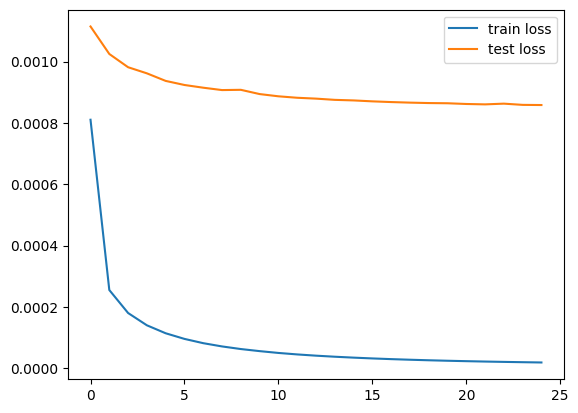

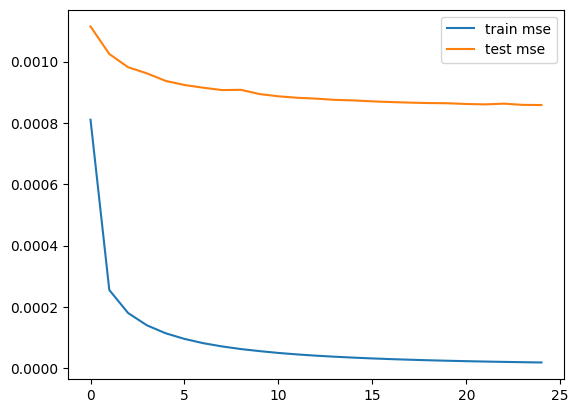

In [15]:
K = 15 # define the size of embeddings, capture the relations in data (10-50)

mu = df_train.interaction.mean()  # Mean interaction for normalization
epochs = 25

u = Input(shape=(1,))
s = Input(shape=(1,))
u_embedding = Embedding(N, K)(u) # (N, 1, K)
s_embedding = Embedding(M, K)(s) # (N, 1, K)


##### main branch
u_bias = Embedding(N, 1)(u) # (N, 1, 1)
s_bias = Embedding(M, 1)(s) # (N, 1, 1)
x = Dot(axes=2)([u_embedding, s_embedding]) # (N, 1, 1)
x = Add()([x, u_bias, s_bias])
x = Flatten()(x) # (N, 1)

# CONTINUOUS BRANCH
continuous_input = Input(shape=(continuous_data_train.shape[1],))


##### side branch
u_embedding = Flatten()(u_embedding) # (N, K)
s_embedding = Flatten()(s_embedding) # (N, K)
y = Concatenate()([u_embedding, s_embedding, continuous_input]) # (N, 2K)
y = Dense(512)(y)
y = Activation('elu')(y)
y = Dropout(0.3)(y)
y = Dense(512)(y)
y = Activation('elu')(y)
y = Dropout(0.3)(y)
y = Dense(512)(y)
y = Activation('elu')(y)
y = Dropout(0.3)(y)
y = Dense(1)(y)


##### merge
x = Add()([x, y])

model = Model(inputs=[u, s, continuous_input], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  #optimizer=Adam(lr=0.001),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)

# Now, train the model
r = model.fit(
  x=[df_train.user_id.values, df_train.song_id.values, continuous_data_train.values],
  y=df_train.interaction.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.user_id.values, df_test.song_id.values, continuous_data_test.values],
    df_test.interaction.values - mu
  )
)

plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['mse'], label="train mse")
plt.plot(r.history['val_mse'], label="test mse")
plt.legend()
plt.show()

In [16]:
import numpy as np

user_ids_test = df_test.user_id.values
song_ids_test = df_test.song_id.values
continuous_features = ["release", "popularity", "danceability", "energy", "key", "mode", "valence", "tempo", "time_of_day"]

# Select a specific user for the prediction
specific_user_id = user_ids_test[0]  # Example: taking the first user in the test set

# Prepare input data for the model
M = interaction_df['song_id'].nunique()  # Total number of unique songs
user_input = np.array([specific_user_id] * M)  # Repeat the user ID for each song
song_input = np.array(range(M))  # Array of all unique song IDs

# Map song IDs to indices in df
song_id_to_index = {id: idx for idx, id in enumerate(interaction_df['song_id'].unique())}

# Prepare continuous data for all songs
continuous_data_input = np.array([interaction_df.loc[song_id_to_index[song_id], continuous_features] for song_id in song_input])

# Make predictions for this user with all songs, including the continuous data
predicted_interactions = model.predict([user_input, song_input, continuous_data_input])


# Convert predictions back to the original scale, if needed
mu = df_train.interaction.mean()  # Mean interaction value for normalization (if used during training)
predicted_interactions = predicted_interactions.flatten() + mu

# Determine the number of top recommendations, e.g., top 10
N = 10
top_n_indices = np.argsort(predicted_interactions)[::-1][:N]

# Convert the indices to original song IDs
top_n_song_ids = song_encoder.inverse_transform(top_n_indices)

# Output the recommended songs
print(f"Top {N} recommended song IDs for user {specific_user_id} are:", top_n_song_ids)


3113/3113 [==============================] - 4s 1ms/step
Top 10 recommended song IDs for user 8 are: ['0YX2G4DtUgctpJXo' '09uARho9w97Dfzgb' '0GdNEDW8Vwu78LXE'
 '07A8gIjr1oCpQQQL' '07A6WHsWKFsZSVNk' '07CXv8n4sD9Fy96e'
 '079yVaWfDrL7ulec' '07AjGMk31TkPW3O9' '09xsSB9n4a4B9x4U'
 '0AJzNGBCKi2IphZ8']


In [17]:
id_information = pd.read_csv('../data/id_information.csv', sep='\t')
id_information.head()

,id,artist,song,album_name
0,0009fFIM1eYThaPg,Cheryl,Rain on Me,3 Words
1,0010xmHR6UICBOYT,Oddisee,After Thoughts,The Beauty in All
2,002Jyd0vN4HyCpqL,Blue Öyster Cult,ME 262,Secret Treaties
3,006TYKNjNxWjfKjy,Rhapsody,Flames of Revenge,Legendary Years (Re-Recorded)
4,007LIJOPQ4Sb98qV,The Chameleons,Nostalgia,What Does Anything Mean? Basically (2009 Remas...


In [18]:
df[df.user_id == specific_user_id].song.unique()

array(['sdvsFE6Y4ChQFw53', 'g7LvlPcwexpFS2xN', 'C2DbDryM4LfOwZwY',
       'OcqSZhhmVmP1zuPX', '3AA71ZgSEhGJYqO5', 'C2yqHJzfjXLos6Od',
       'fmhBHufXXkFOhPkV', 'm0bUJjtPS7Oti4dl', 'WAvgLynWBp6nBGe4',
       'U4yu3HzCz9FEvfPF', 'w3Bg3iP0fgb7fvfT', 'Pocetc7AP7RYKjDA',
       'NhdupQW4QNq6Jcqd', 'kp3hyNSqgNXW3FKi', 'KcpSMlBX1KFAvz5Y',
       '4rbvP2ZF2o9Bnv05', '29qPz9aGO6jdkDqm', 'xupOu9psHLlU8iAa',
       'WhrnmoJW1G6tHQdp', 'h0zy6uzEvWDp1vmp', '3MSpqlJj3jOoDuvl',
       'nAXy2vKOKDZqbw2w', '2zGGJEwJJA58gOds', 'V1eO74AwUM3SBovw',
       'PurmndY7sowGWoYi', 'yUr7QyMieGv2qywR', 'Fm4b5cVhIkNgP8ut',
       'SEgkWiiw2sUChgqt', 'xVxOf1PZl7zpocwv', 'TEC2PTxd9QFmzbAC',
       'PCU7QQiiP7Qu5gtq', 'PJUo1qkmu1bGcKwj', 'ftMo4oQwuuCiLw1F',
       'ysJ6UdPQrjDpvPvB', 'ZQki8qio7CdYxs7H', 'eLe0TZPo0BAkVBJn',
       'DumKMrdj7k633p92', 'JSwbsGa8SCWCS8ew', 'Zwq0iMA0iOLqNgST',
       '3oxgv9GLRUJdaBiW', '2iZxESuXBVBGKFcC', 'HGQfkq5TM9aue46n',
       'sSS9j3MjJcTLMEpg', 'V8hJK8mWXccbpxyX', 'S3E7SN5cU6BL4C

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Example song features DataFrame
# Assume df_features is a DataFrame with songs as rows and features as columns

# Calculate similarity
def calculate_similarity(target_song_features, songs_features):
    similarity = cosine_similarity([target_song_features], songs_features)
    return similarity[0]  # similarity[0] because the result is in a 2D array

maxi = -1
best_idx = 0
last_5_song_ids = list()

#REWORKa
last_5_song_ids = ['aPPVq97XeQv8mqsU', 'SSA3WorrB4G8ww60', 'lJKIbZNzpS6IsNgh', 'd8QDyWffh9zwJ4Gs', 'oLHuLrmZyV1oEfdu']
#print(last_5_song_ids)


for i in range(10):
    recommended_song_id = top_n_song_ids[i]
    # Get the feature vector for the recommended song
    recommended_song_features = interaction_df.loc[interaction_df.song_id[song_indices[recommended_song_id]]]

    # Get the feature vectors for the last 5 played songs
    last_5_songs_features = np.array([interaction_df.loc[interaction_df.song_id[song_indices[song_id]]] for song_id in last_5_song_ids])

    # Calculate similarity
    similarities = calculate_similarity(np.array(recommended_song_features).reshape(1, -1)[0], last_5_songs_features)
    print(np.sum(similarities), end = "\n\n\n")
    
    if np.sum(similarities) > maxi:
        maxi = np.sum(similarities)
        best_idx = i
print()
print()
print(maxi, best_idx)

4.998933889524318


4.999234246439509


4.999273808478957


4.999185805491581


4.998780652943894


4.99927062475909


4.99870129274966


4.999196786881341


4.998883937296593


4.999250563115453




4.999273808478957 2


In [20]:
recommended_song_id = top_n_song_ids[best_idx]
id_information[id_information.id == recommended_song_id]

,id,artist,song,album_name
450,0GdNEDW8Vwu78LXE,Celldweller,Lost in Time,End of an Empire (Deluxe Edition)


In [21]:
last_5_songs_info = id_information[id_information['id'].isin(last_5_song_ids)]

# Display the information of the last 5 songs
print(last_5_songs_info)

                     id             artist                  song  \
50240  SSA3WorrB4G8ww60          blink-182  All the Small Things   
64094  aPPVq97XeQv8mqsU        Fleet Foxes               Mykonos   
68866  d8QDyWffh9zwJ4Gs           The 1975         Be My Mistake   
83374  lJKIbZNzpS6IsNgh  Foster the People       Pumped Up Kicks   
88650  oLHuLrmZyV1oEfdu           The 1975                  Mine   

                                      album_name  
50240                         Enema Of The State  
64094                 First Collection 2006-2009  
68866  A Brief Inquiry Into Online Relationships  
83374                                    Torches  
88650  A Brief Inquiry Into Online Relationships  


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

def get_relevant_songs(user_id, df):
    """
    Get a list of relevant songs for a given user.
    This function needs to be adapted based on how relevance is defined in your dataset.
    """
    # Example: get songs that the user has interacted with
    return df[df.user_id == user_id]['song'].unique()

# Select a user and predict top N songs
specific_user_id = user_ids_test[0]
predicted_interactions = model.predict([user_input, song_input, continuous_data_input])
flattened_arr = predicted_interactions.flatten()

# Sort the array in descending order
sorted_indices = np.argsort(flattened_arr)[::-1]
sorted_arr = flattened_arr[sorted_indices]

# Get actual relevant songs for the user
actual_relevant_songs = get_relevant_songs(specific_user_id, df)

# Convert actual relevant songs and top recommended songs to a binary format
actual_binary = [1 if song_encoder.inverse_transform([song_id])[0] in actual_relevant_songs else 0 for song_id in song_ids_test]
predicted_binary = [1 if song_id in sorted_indices[:len(actual_relevant_songs)].tolist() else 0 for song_id in song_ids_test]

# Calculate precision, recall, and F1 score
precision = precision_score(actual_binary, predicted_binary)
recall = recall_score(actual_binary, predicted_binary)
f1 = f1_score(actual_binary, predicted_binary)

print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

3113/3113 [==============================] - 5s 1ms/step
Precision: 5.039560550320012e-05, Recall: 0.0006317119393556538, F1 Score: 9.334453467749461e-05


In [23]:
relevant = list()
for song_id in actual_relevant_songs:
    relevant.append(song_indices[song_id])
relevant

[268,
 523,
 526,
 827,
 828,
 855,
 932,
 944,
 945,
 960,
 986,
 995,
 996,
 997,
 998,
 1233,
 1419,
 1437,
 1505,
 1506,
 1507,
 1508,
 1509,
 1510,
 1511,
 1512,
 1513,
 1514,
 1515,
 1516,
 1517,
 1518,
 1519,
 1520,
 1521,
 1522,
 1523,
 1524,
 1525,
 1526,
 1527,
 1528,
 1529,
 1530,
 1531,
 1532,
 1533,
 1534,
 1535,
 1536,
 1537,
 1538,
 1539,
 1540,
 1541,
 1542,
 1543,
 1544,
 1545,
 1546,
 1547,
 1548,
 1549,
 1550,
 1551,
 1552,
 1553,
 1554,
 1555,
 1556,
 1557,
 1558,
 1559,
 1560,
 1561,
 1562,
 1563,
 1564,
 1565,
 1566,
 1567,
 1568,
 1569,
 1570,
 1571,
 1572,
 1573,
 1574,
 1575,
 1576,
 1577,
 1578,
 1579,
 1580,
 1581,
 1582,
 1583,
 1584,
 1585,
 1586,
 1587,
 1588,
 1589,
 1590,
 1591,
 1592,
 1593,
 1594,
 1595,
 1596,
 1597,
 1598,
 1599,
 1600,
 1601,
 1602,
 1603,
 1604,
 1605,
 1606,
 1607,
 1608,
 1609,
 1610,
 1611,
 1612,
 1613,
 1614,
 1615,
 1616,
 1617,
 1618,
 1619,
 1620,
 1621,
 1622,
 1623,
 1624,
 1625,
 1626,
 1627,
 1628,
 1629,
 1630,
 1631,
